In [2]:
from preprocessing import *
from word_swap import *
from activations import *
import torch
from transformers import AutoTokenizer,AutoModel,pipeline
from nltk.corpus import brown
import matplotlib
import matplotlib.pyplot as plt

# Laod a custom color map for better visualization
from scipy.io import loadmat
colormap = loadmat('colormap-custom-lightblue-to-yellow1.mat')['cmap']
colormap = matplotlib.colors.ListedColormap(colormap)

# Obtaining and preprocessing a corpus

For simplicity of demonstration, we use the Brown Corpus, conveniently available from NLTK. The Brown Corpus is a collection of English-language text, totaling roughly one million words, compiled from works published in the United States in 1961. The corpus is divided into 15 genres, such as news, editorial, and fiction; for this demonstration, we use the entire corpus. The files are further divided into sentences and tagged with part-of-speech (POS) tags. For more information on the Brown Corpus, see the [NLTK documentation](http://www.nltk.org/book/ch02.html#brown-corpus).

The following code imports the Brown Corpus preprocesses each sentence. The preprocessing:
- Removes punctuation
- Converts all words to lowercase

Additionally, this step removes sentences containing proper nouns or non-alphabetical characters.

In [3]:
corpus = Corpus(brown)

  0%|          | 0/57340 [00:00<?, ?it/s]

  0%|          | 0/1004244 [00:00<?, ?it/s]

We can filter the preprocessed sentences to retain only those having particular lengths:

In [4]:
selected_sentences = corpus.get_sentences_of_length(12)

For example, we inspect the first five 12-word sentences:

In [5]:
[" ".join(selected_sentences[i]) for i in range(5)]

['under committee rules it went automatically to a subcommittee for one week',
 'nothing has been done yet to take advantage of the enabling legislation',
 'how can a man with any degree of common decency charge this',
 'he then launched into what the issues should be in the campaign',
 'there is a tangible feeling in the air of revulsion toward politics']

We can also similarly extract and preprocess sequences of natural text (not necessarilly delimited by sentence boundaries):

In [6]:
natural_sequences = corpus.get_natural_sequences_of_length(40)

In [7]:
for i,word in enumerate(natural_sequences[0][:10]):
    print(f"{i} {word}:{corpus.word_lookup[word]}")

0 party:NN-HL
1 leaders:NNS-HL
2 came:VBD-NC
3 out:RB-NC
4 of:NIL
5 the:NIL
6 final:JJ-HL
7 meeting:VBG-HL
8 apparently:QL
9 satisfied:VBN


The Corpus object also has a dictionary that allows one to lookup words having a given POS-tag, e.g., adjectives (`JJ`):

In [8]:
corpus.pos_dict["JJ"][:10]

['navy',
 'supplemental',
 'diatomic',
 'organic',
 'duplex',
 'prospective',
 'practical',
 'faceless',
 'irresistible',
 'faroff']

Lastly, one can similarly extract noun phrases from the corpus. For convenience, we repurpose the preprocessed sentences obtained above.

In [9]:
noun_phrases = corpus.get_noun_phrases_of_length(8)

In [10]:
[" ".join(noun_phrases[i]) for i in range(5)]

['the entire two and a half mile length',
 'the same three month period toll road bonds',
 'the only or even the most appropriate conceptuality',
 'the intellectual social political and economic attitudes institutions',
 'the true color texture complexity range intensity pulse']

# Word swap procedure

Now that the corpus has been preprocessed, we can create sequences and perform the word swap procedure. The nature of the input sequences and the method of selecting the swapped word vary with the analysis at hand, but the word swap procedure remains the same. Specifically:

- To assess overall integration, we use sequences of natural text(e.g., of 40 words in length), and make swaps using randomly selected words having the same POS-tag.
- To assess structure yoking, we create sequences of five structures of prespecified length (e.g., 12-word sentences), and make swaps from a pool of words selected based on the difference in the embeddings betwen the original and candidate words.
- We also consider making swaps using probable (or improbable) words, as determined (independently) by BERT.

We found that sentence-final words yielded slightly more tokens on average than words in other positions. To account for this in the structure yoking analysis, we tokenize all candidate sentences and used only those that are comprised entirely of single-token words.

One can instantiate a tokenizer and model as follows:


In [11]:
model_type = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(
    model_type, add_special_token=False,add_prefix_space=True)
model = AutoModel.from_pretrained(model_type)

The Corpus also needs to be reinitialized with the new tokenizer:

In [12]:
corpus = Corpus(brown,single_token_words=True,tokenizer=tokenizer)

  0%|          | 0/57340 [00:00<?, ?it/s]

  0%|          | 0/1004244 [00:00<?, ?it/s]

GPT-2 does not have any structure-delimiting tokens. Other models (e.g., BERT) do have such tokens, which need to be excluded.

In [13]:
yoking_sequences = create_yoking_sequences(
    sentences = corpus.get_sentences_of_length(12),
    tokenizer = tokenizer,
    excluded_token_ids = []
)

In [14]:
" ".join(yoking_sequences[0][:24])

'but if there is no line how can there be two countries males and mating females do not emerge until later in the season'

In [15]:
pos_swapper = RandomPosWordSwap(corpus.word_lookup,corpus.pos_dict,tokenizer)
pos_swapper(yoking_sequences[:250])

0it [00:00, ?it/s]

After calling them on an appropriate list of sequences, the word swap objects have attributes `swapped` and `original_sequences` that contain the swapped and original sequences, respectively. `swapped` is a list of lists: `swapped[i][j]` is the ith sequence with the jth word swapped. Indices are zero-indexed.

In [16]:
i = 0
j = 5
print("Original: " + " ".join(pos_swapper.original_sequences[i][:10]) + " ..."),
print(f"Swapped at {j}: " + " ".join(pos_swapper.swapped[i][j][:10]) + " ...") 
print(f"Swapped at {j+1}: " + " ".join(pos_swapper.swapped[i][j+1][:10]) + " ...") 

Original: but if there is no line how can there be ...
Swapped at 5: but if there is no publish how can there be ...
Swapped at 6: but if there is no line wherever can there be ...


Let's also see how the other swap procedures work:

In [17]:
word_list = list(corpus.word_lookup.keys())
word_list,tokens = filter_word_list(word_list, tokenizer,[])
candidate_embeddings = create_candidate_embeddings(tokens,model.base_model.wte.forward)
sampling_params = {'mean':.125,'half_width':.003,'spacing':.001,'size':100}
distribution_swapper = DistributionWordSwap(word_list,
                                            candidate_embeddings,
                                            model.base_model.wte.forward,
                                            sampling_params,
                                            tokenizer,
                                            excluded_token_ids = [])


  0%|          | 0/14999 [00:00<?, ?it/s]

Candidate embeddings created of shape:  torch.Size([14999, 768])


In [18]:
distribution_swapper(yoking_sequences[:10])

0it [00:00, ?it/s]

In [19]:
print("Original: " + " ".join(distribution_swapper.original_sequences[i][:10])),
print(f"Swapped at {j}: " + " ".join(distribution_swapper.swapped[i][j][:10])) 
print(f"Swapped at {j+1}: " + " ".join(distribution_swapper.swapped[i][j+1][:10])) 

Original: but if there is no line how can there be
Swapped at 5: but if there is no las how can there be
Swapped at 6: but if there is no line cleaners can there be


In [20]:
unmasker = pipeline('fill-mask',model = 'bert-large-uncased-whole-word-masking',top_k=1000,device='cpu')
probable_swapper = ProbableWordSwap(unmasker,idx_low = 0,idx_high = 5,sentence_len = 12,excluded_token_ids = [])
probable_swapper(yoking_sequences[:10])


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0it [00:00, ?it/s]

In [21]:
print("Original: " + " ".join(probable_swapper.original_sequences[i][:10])),
print(f"Swapped at {j}: " + " ".join(probable_swapper.swapped[i][j][:10])) 
print(f"Swapped at {j+1}: " + " ".join(probable_swapper.swapped[i][j+1][:10])) 

Original: but if there is no line how can there be
Swapped at 5: but if there is no peace how can there be
Swapped at 6: but if there is no line where can there be


# Obtaining activations

Having obtained the swapped sequences, we can now obtain activations for each sequence. The activations are obtained by passing the sequences through an LLM and extracting the activations. Typically, the 0th layer of the LLM is a non-contextual embedding layer; subsequent layers are contextual. 

Unless one has restricted the analysis to only single-token words, some words will likely be tokenized into multiple tokens. In this case, we take the mean of the activations for the tokens comprising the word. We do this by first creating a Pandas DataFrame from the text, which makes it convenient to track which tokens correspond to each word. The funcion that extacts the activations takes this DataFrame as input.

In [22]:
text_to_df(probable_swapper.original_sequences[0],tokenizer=tokenizer)

word   tokens  n_tokens_in_word         decoded
0           but    [475]                 1          [Ġbut]
1            if    [611]                 1           [Ġif]
2         there    [612]                 1        [Ġthere]
3            is    [318]                 1           [Ġis]
4            no    [645]                 1           [Ġno]
5          line   [1627]                 1         [Ġline]
6           how    [703]                 1          [Ġhow]
7           can    [460]                 1          [Ġcan]
8         there    [612]                 1        [Ġthere]
9            be    [307]                 1           [Ġbe]
10          two    [734]                 1          [Ġtwo]
11    countries   [2678]                 1    [Ġcountries]
12        males  [10835]                 1        [Ġmales]
13          and    [290]                 1          [Ġand]
14       mating  [31993]                 1       [Ġmating]
15      females  [12366]                 1      [Ġfemales]
16           do    [466]                 1           [Ġdo]
17          not    [407]                 1          [Ġnot]
18       emerge  [14740]                 1       [Ġemerge]
19        until   [1566]                 1        [Ġuntil]
20        later   [1568]                 1        [Ġlater]
21           in    [287]                 1           [Ġin]
22          the    [262]                 1          [Ġthe]
23       season   [1622]                 1       [Ġseason]
24    obviously   [6189]                 1    [Ġobviously]
25           we    [356]                 1           [Ġwe]
26         cant  [18548]                 1         [Ġcant]
27         stop   [2245]                 1         [Ġstop]
28         them    [606]                 1         [Ġthem]
29         from    [422]                 1         [Ġfrom]
30       coming   [2406]                 1       [Ġcoming]
31           in    [287]                 1           [Ġin]
32      however   [2158]                 1      [Ġhowever]
33         just    [655]                 1         [Ġjust]
34           by    [416]                 1           [Ġby]
35         talk   [1561]                 1         [Ġtalk]
36          but    [475]                 1          [Ġbut]
37         from    [422]                 1         [Ġfrom]
38          the    [262]                 1          [Ġthe]
39        start    [923]                 1        [Ġstart]
40         they    [484]                 1         [Ġthey]
41          had    [550]                 1          [Ġhad]
42          two    [734]                 1          [Ġtwo]
43    important   [1593]                 1    [Ġimportant]
44  ingredients   [9391]                 1  [Ġingredients]
45    sincerity  [44053]                 1    [Ġsincerity]
46          and    [290]                 1          [Ġand]
47      realism  [30787]                 1      [Ġrealism]
48          how    [703]                 1          [Ġhow]
49          did    [750]                 1          [Ġdid]
50          one    [530]                 1          [Ġone]
51       attach  [10199]                 1       [Ġattach]
52     anything   [1997]                 1     [Ġanything]
53           to    [284]                 1           [Ġto]
54            a    [257]                 1            [Ġa]
55        stone   [7815]                 1        [Ġstone]
56         wall   [3355]                 1         [Ġwall]
57          for    [329]                 1          [Ġfor]
58         that    [326]                 1         [Ġthat]
59       matter   [2300]                 1       [Ġmatter]

In [23]:
swapped_seqs = pos_swapper.swapped
original_seqs = pos_swapper.original_sequences
differences = calculate_differences(swapped_seqs,original_seqs,tokenizer,model,device='cuda')

0it [00:00, ?it/s]

Finished calculating difference tensor for  250  sequences


In [24]:
differences.shape

torch.Size([13, 60, 60, 768])

# Reproducing analyses

This section walks through the reproduction of some of the figures. The remaining figures can be reproduced by making small changes to the code below, e.g., changing the model type, the swap procedure, the structure length (e.g., 12-word sentences), or the structure type.

## Overall integration

First, we instantiate the model (here, GPT-2), tokenizer, corpus, and swapper. For the overall integration analysis, we select swaps randomly from a pool of words having the same POS-tag (i.e., using the `RandomPosWordSwap` swapper). We then extract natural sequences of 40 words.

In [25]:
model_type = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(
    model_type, add_special_token=False,add_prefix_space=True)
model = AutoModel.from_pretrained(model_type)
overall_integration_corpus = Corpus(brown,single_token_words=False,tokenizer=tokenizer)
overall_integration_swapper = RandomPosWordSwap(overall_integration_corpus.word_lookup,
                                                overall_integration_corpus.pos_dict,
                                                tokenizer)
natural_sequences_40 = overall_integration_corpus.get_natural_sequences_of_length(40)
len(natural_sequences_40)

  0%|          | 0/57340 [00:00<?, ?it/s]

  0%|          | 0/1004244 [00:00<?, ?it/s]

114

We perform the swap procedure, obtain activations, and calulate the difference:

In [26]:
overall_integration_swapper(natural_sequences_40)
differences = calculate_differences(overall_integration_swapper.swapped,
                                    overall_integration_swapper.original_sequences,
                                    tokenizer,model,device='cuda')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Finished calculating difference tensor for  114  sequences


After transposing the differences appropriately, we fit the activation windows as a convex combination of exponential and power-law functions using the function `fit_curves`. This function returns the fitted parameters (assigned to `all_fits` below), as well as the integration windows themselves (`all_D_delta`).

In [27]:
from analysis import *
print("differences shape: ",differences.shape)
D = np.transpose(differences.numpy(), (3, 1, 2, 0))
print("D shape: ",D.shape)
n_features, n_stim_time, n_model_time, n_layers = D.shape
all_fits, all_D_delta = fit_curves(D)

differences shape:  torch.Size([13, 40, 40, 768])
D shape:  (768, 40, 40, 13)


  0%|          | 0/768 [00:00<?, ?it/s]

The parameters are returned as nested lists: converting this into a single tensor:

In [28]:
stacked_fits = [np.stack(fit) for fit in all_fits]
stacked_fits = np.stack(stacked_fits)
stacked_fits.shape

(768, 13, 3)

In [29]:
from plots import *

The following plots use slightly modified versions of the functions in plots.py, with changes add annotations and reformat for presentation in this notebook.

Reproducing figure 2B:

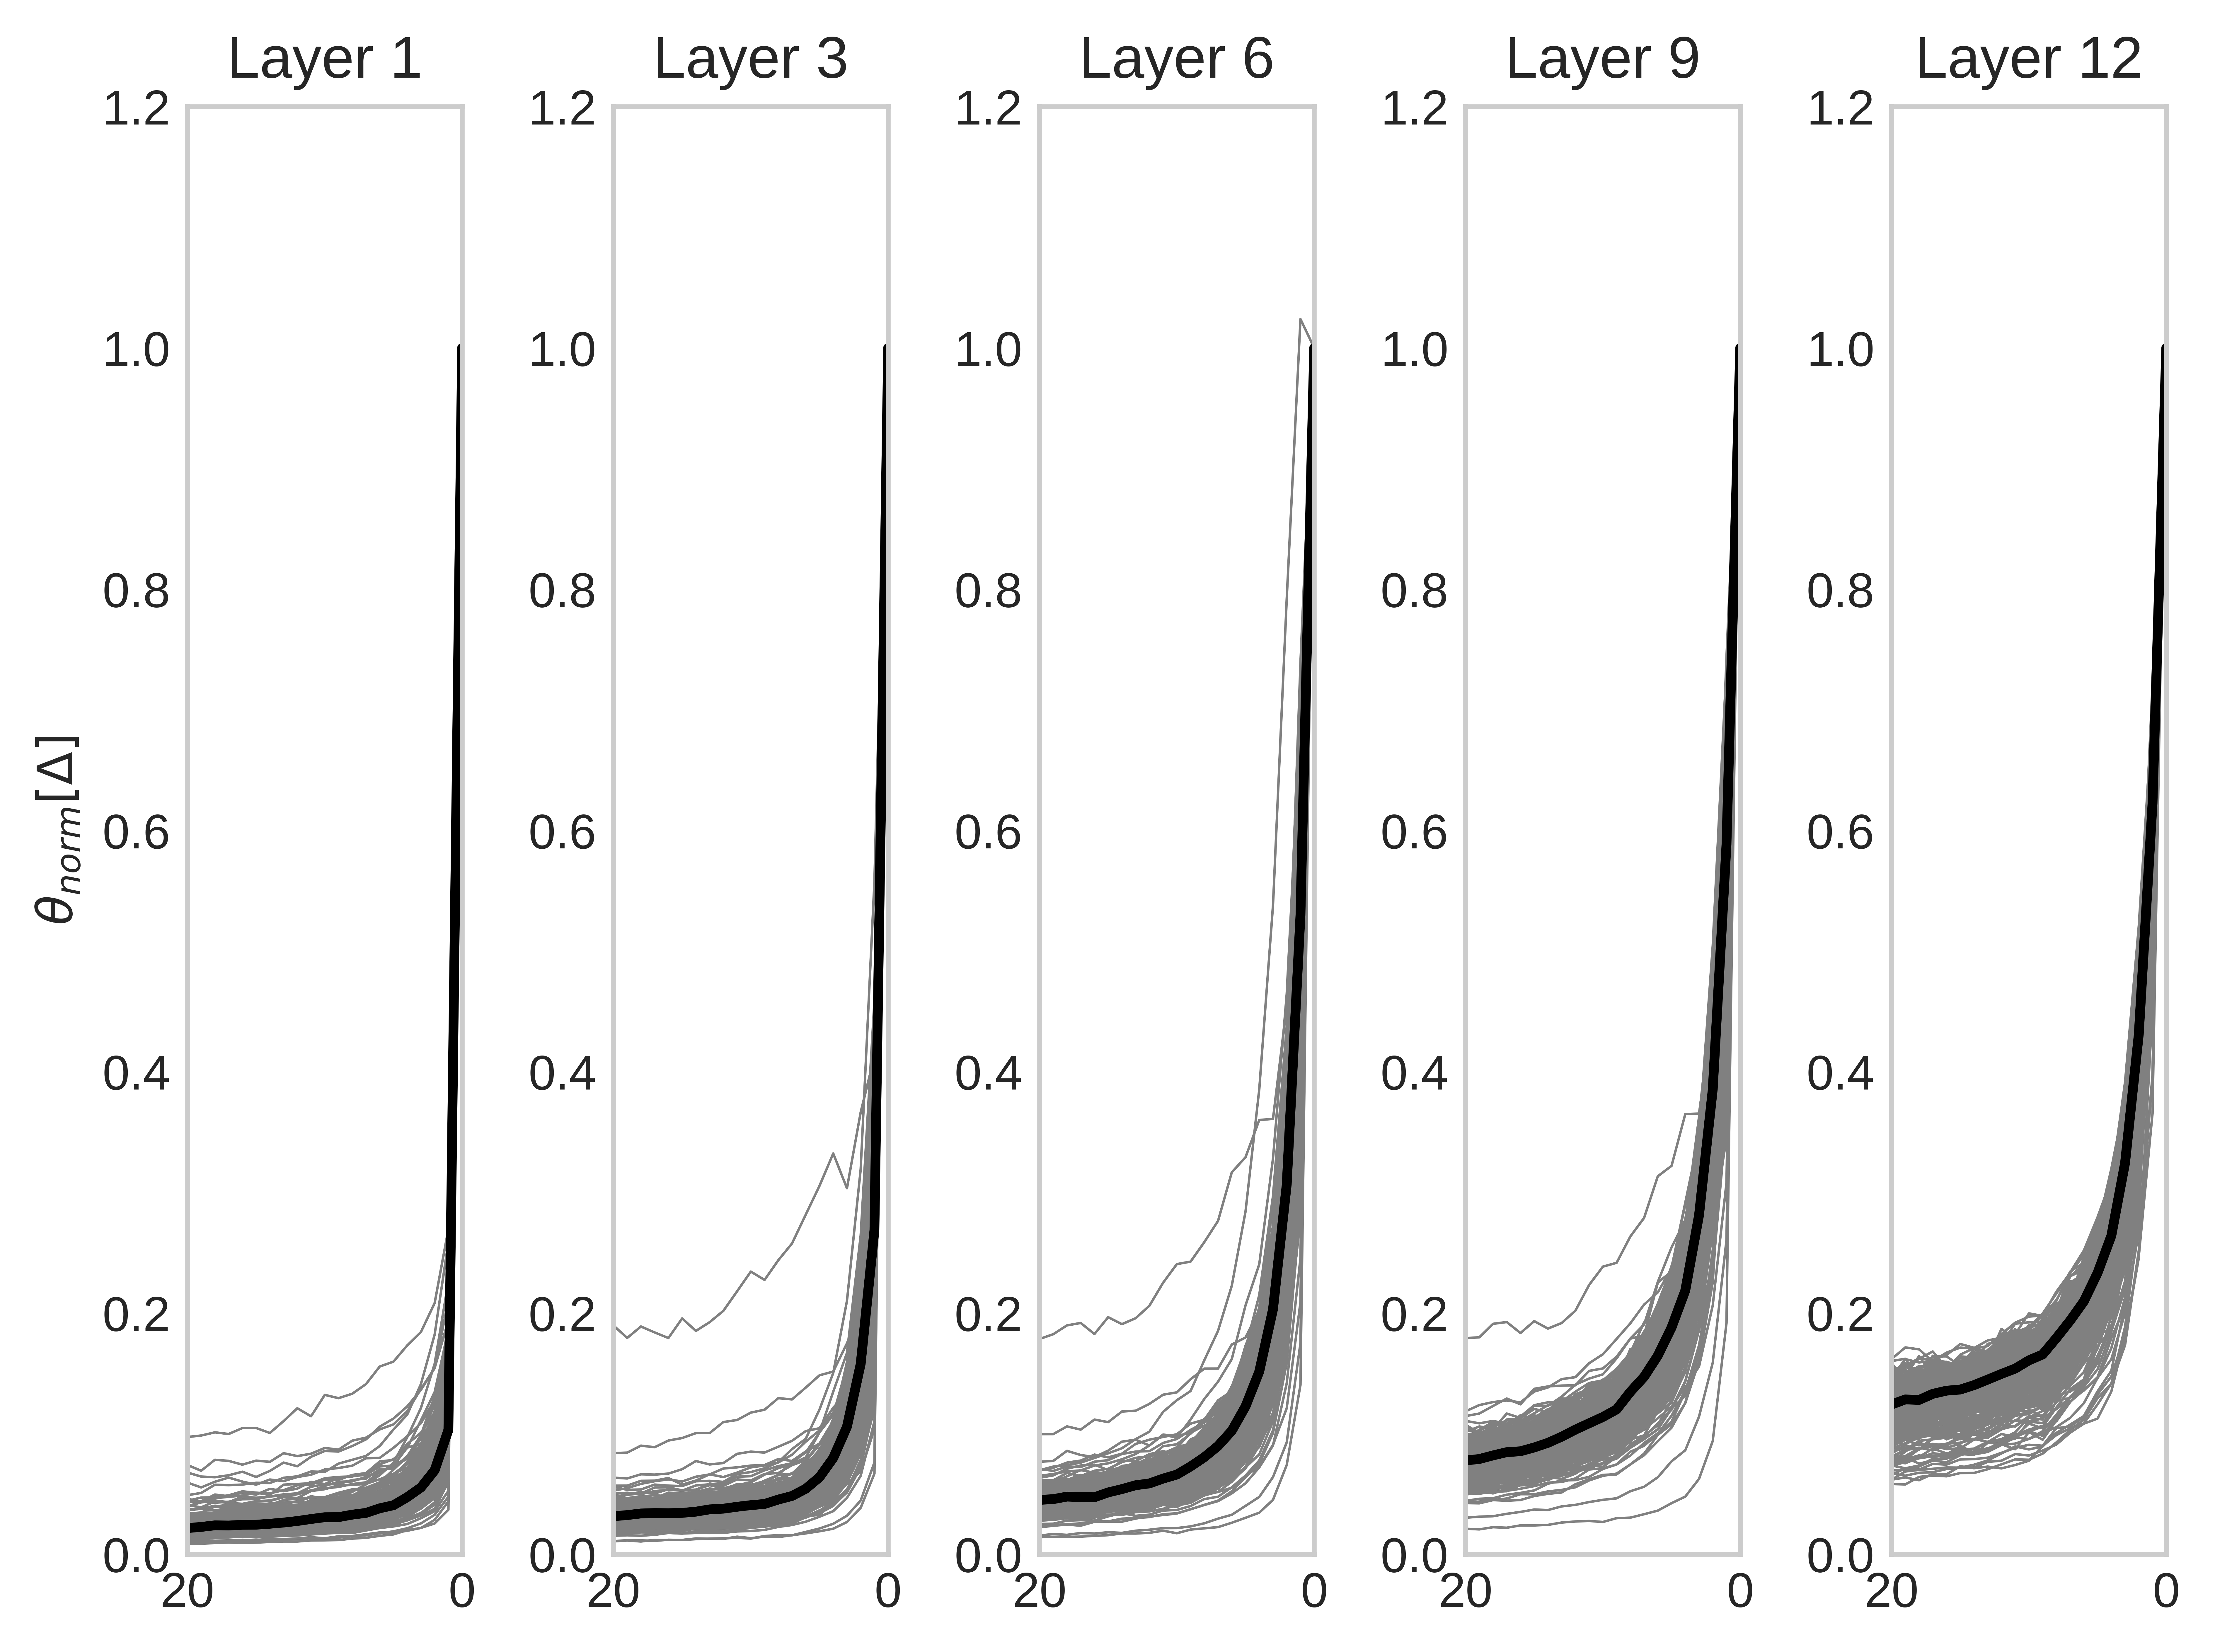

In [30]:
def average_over_units_indiv_plots(layers,fitobj,D_delta):  
    # plot differences and fits
    max_window_size = 21
    idx = 0
    t = np.arange(0,max_window_size)
    D_delta_all = np.stack(D_delta,0).mean(0)
    fig,axes = plt.subplots(1,len(layers))
    for k,layer in enumerate(layers):
        ax = axes.flat[k]


        for u in D_delta:
            ax.plot(t, np.median(u[:, :, layer],axis=1), color='gray',label = 'Indiv.' '\n' 'Units',linewidth=.5)
        ax.plot(t, np.median(D_delta_all[:, :, layer], axis=1), color = 'black', linestyle="-", linewidth=2,label="Mean")
        ax.set_ylim([0, 1.2])
        
        
        ax.set_xlim([0, max_window_size - 1])

        #     ax.set_xticks([])
        # ax.tick_params(labelright= False,labeltop= False,labelleft= False, labelbottom= False)
        ax.set_title(f"Layer {layer}")
        ax.grid(False)        
        ax.invert_xaxis()
        if k == 0:
            ax.set_ylabel(r"$\theta_{norm}[\Delta]$")
        idx += 1
    fig.tight_layout()
        
average_over_units_indiv_plots([1,3,6,9,12],all_fits,all_D_delta)

And figure 2D:

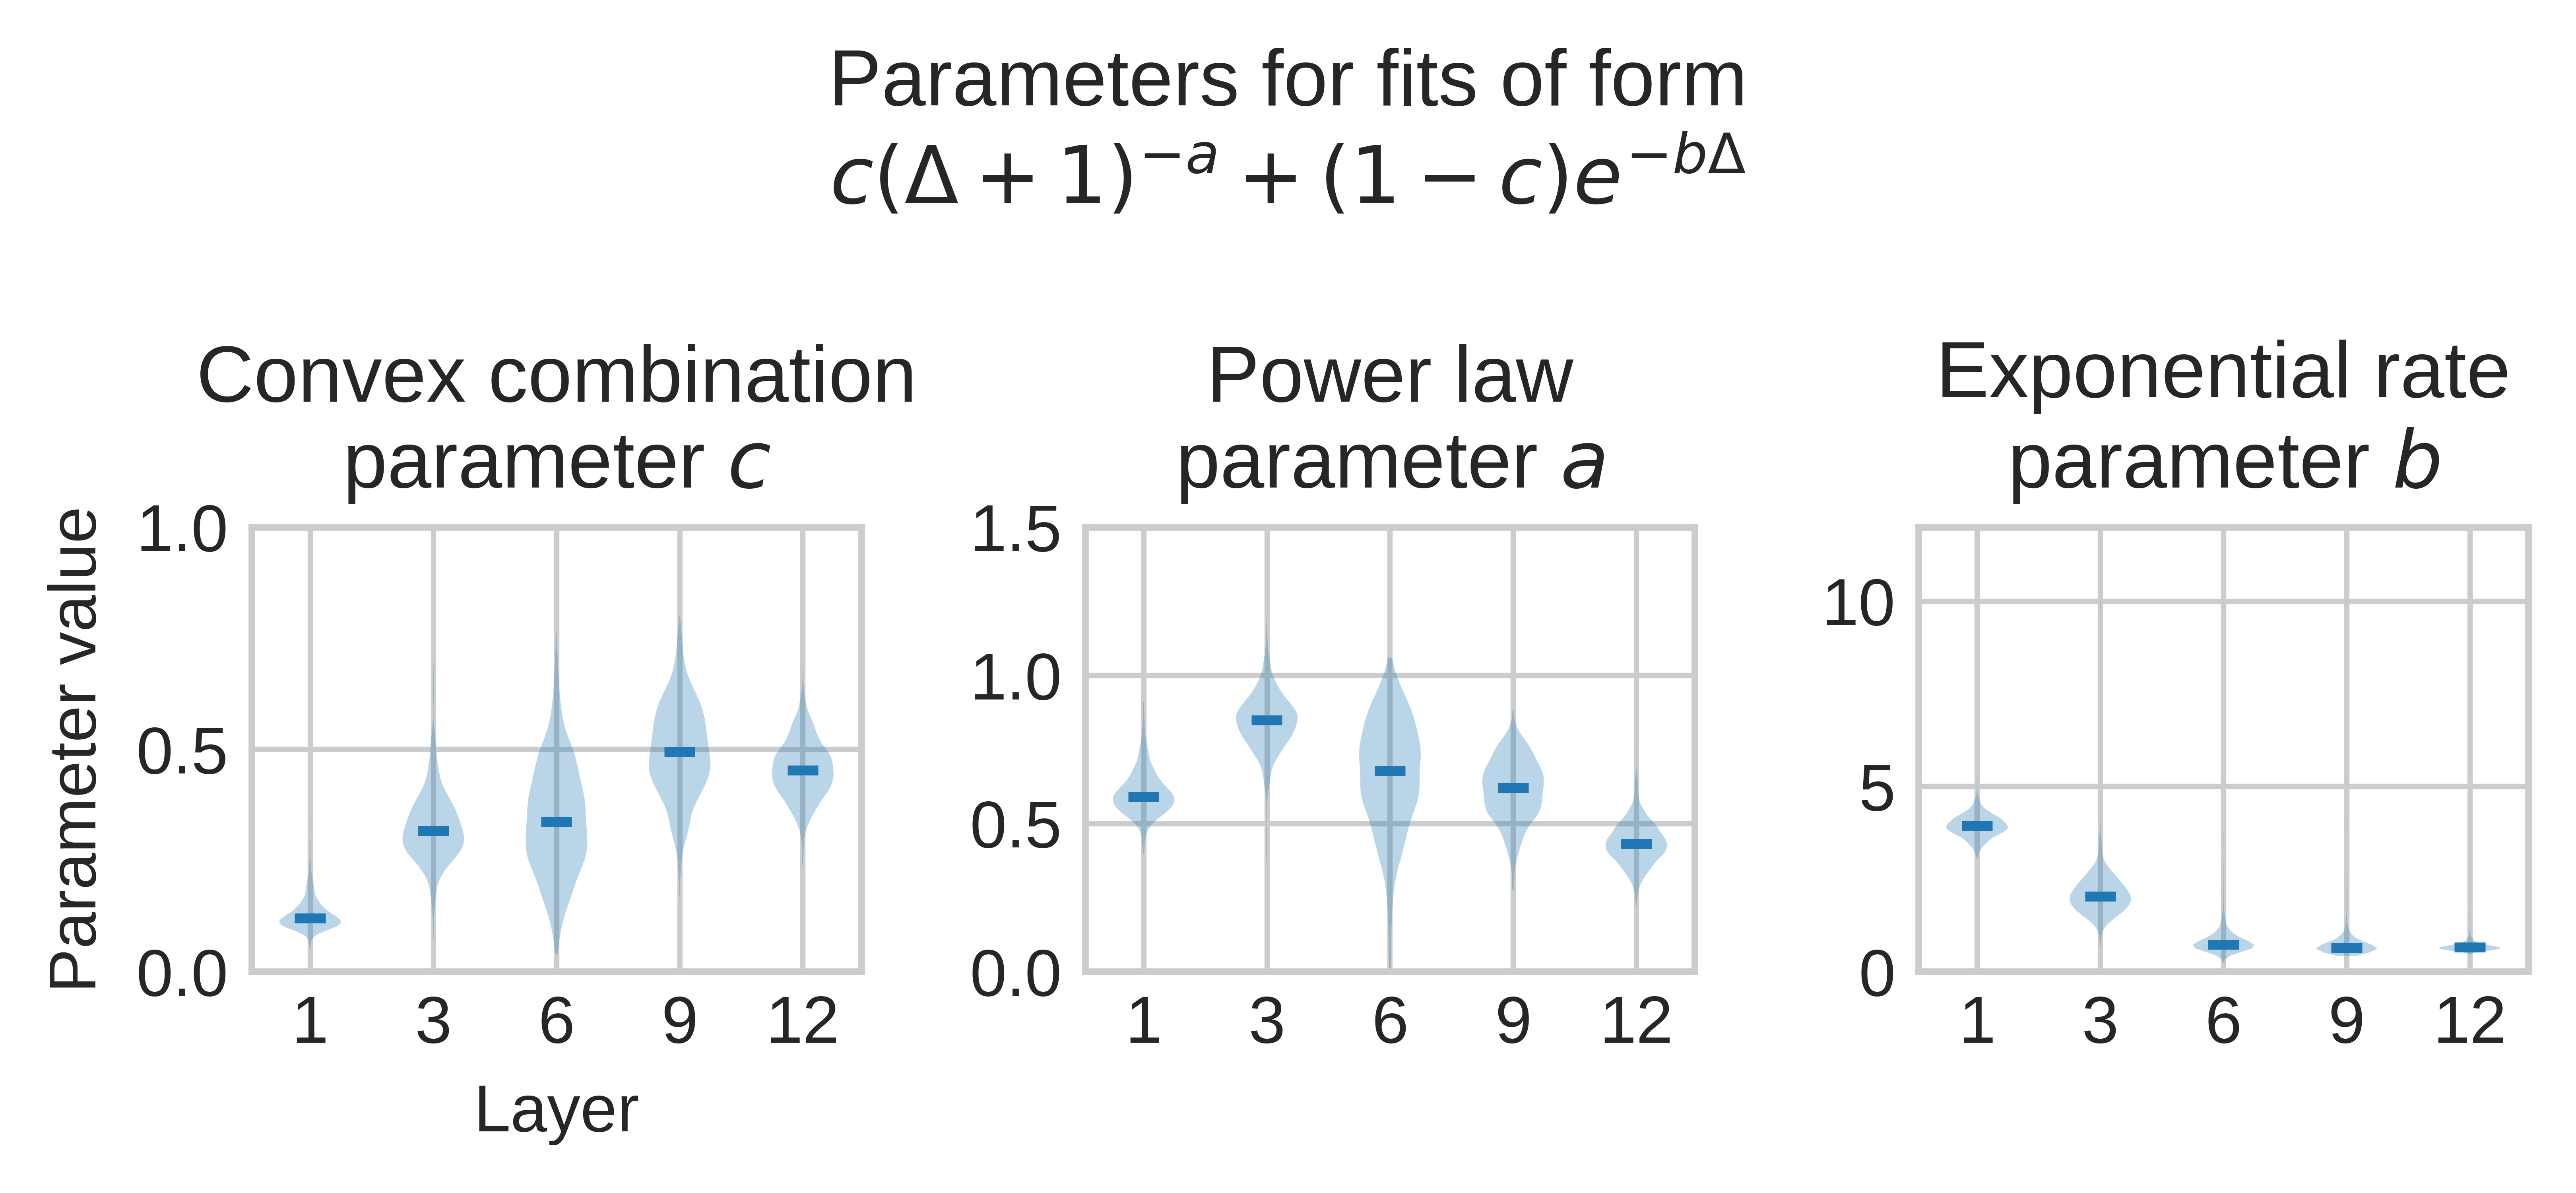

In [31]:
plot_fit_params(stacked_fits)

## Structure yoking

In the structure yoking analysis, we restrict the sentences to those containing only single-token words (accomplished here by setting `single_token_words = True` in the instaniation of `structure_yoking_corpus`). We also use the `DistributionWordSwap` swapper, which selects words based on the difference in the embeddings between the original and candidate words. This requires us to create a word list, candidate embeddings (a large matrix of precalculated embeddings for many words), and to define some sampling parameters for the swapper as shown below. 

The function `create_candidate_embeddings` takes as inputs tokens and a function to obtain embeddings; it outputs a large matrix that has dimensions (vocabulary x feature) that contains the embeddings corresponding to the tokens. This allows us to calculate the embeddings for a large number of possible words once, effectively caching it for later use.

In [32]:
# Reinitialize model and tokenizer
model_type = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(
    model_type, add_special_token=False,add_prefix_space=True)
model = AutoModel.from_pretrained(model_type)

#Reinstantiate corpus
structure_yoking_corpus = Corpus(brown,single_token_words=True,tokenizer=tokenizer)

# Create word list by extracting keys from word_lookup
word_list = list(structure_yoking_corpus.word_lookup.keys())

# The corpus was initialized to contain only single-token words, so filtering is not necessary
# However, this function is a convenient was to obtain tokens.
word_list,tokens = filter_word_list(word_list, tokenizer,[])

# We calculate 'candidate_embeddings' by passing the tokens to the model's embedding layer
candidate_embeddings = create_candidate_embeddings(tokens,model.base_model.wte.forward)
sampling_params = {'mean':.125,'half_width':.003,'spacing':.001,'size':100}
structure_yoking_swapper = DistributionWordSwap(word_list,
                                            candidate_embeddings,
                                            model.base_model.wte.forward,
                                            sampling_params,
                                            tokenizer,
                                            excluded_token_ids = [])

yoking_sequences = create_yoking_sequences(
    sentences = corpus.get_sentences_of_length(12),
    tokenizer = tokenizer,
    excluded_token_ids = []
)

len(yoking_sequences)

  0%|          | 0/57340 [00:00<?, ?it/s]

  0%|          | 0/1004244 [00:00<?, ?it/s]

  0%|          | 0/14999 [00:00<?, ?it/s]

Candidate embeddings created of shape:  torch.Size([14999, 768])


250

Note: the swapper prints out any words for which a suitable swap cannot be found. It selects a random word in that case. 

In [33]:
structure_yoking_swapper(yoking_sequences)
differences_yoking = calculate_differences(structure_yoking_swapper.swapped,
                                    structure_yoking_swapper.original_sequences,
                                    tokenizer,model,device='cuda')

0it [00:00, ?it/s]

Using random word sub for:  throats
Using random word sub for:  throats
Using random word sub for:  throats
Using random word sub for:  throats
Using random word sub for:  stride
Using random word sub for:  throats
Using random word sub for:  throats
Using random word sub for:  stride
Using random word sub for:  throats
Using random word sub for:  throats
Using random word sub for:  stride
Using random word sub for:  stride


0it [00:00, ?it/s]

Finished calculating difference tensor for  250  sequences


We can visualize the results as a heatmap, as in figure 3B:

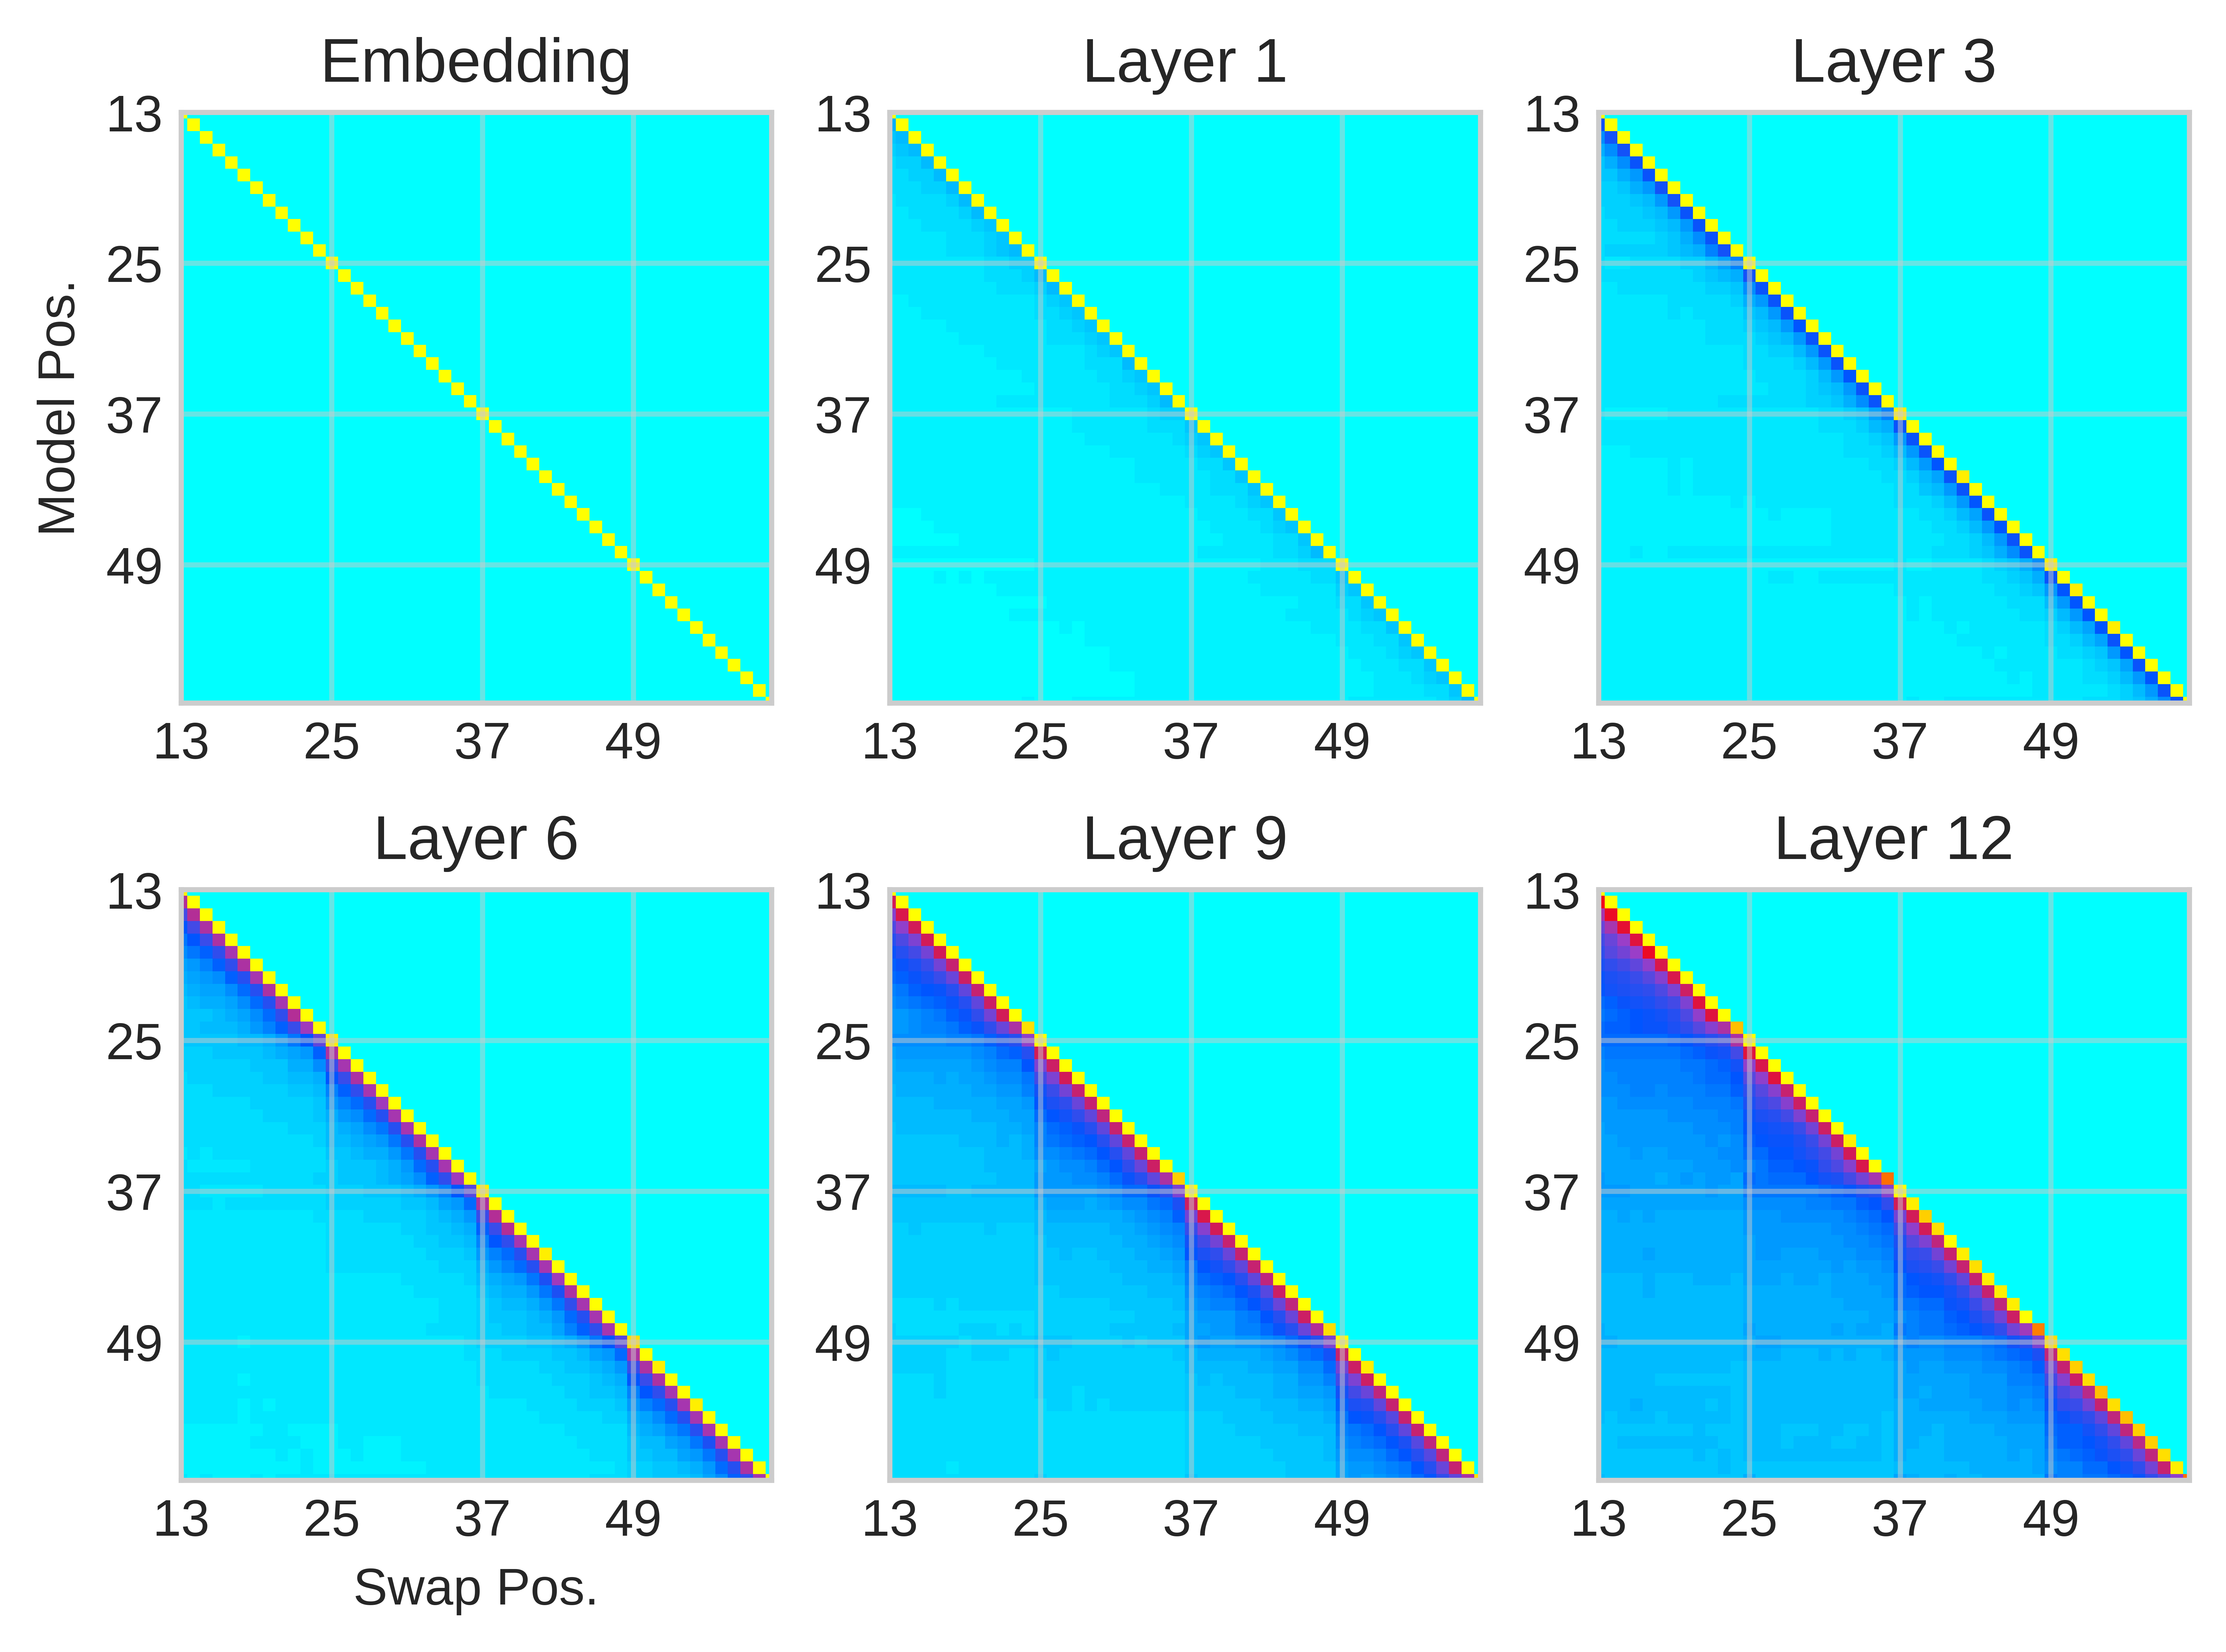

In [34]:
def plot_difference_tensor_individual_layers(D,layers):
    """Plot the difference tensor for each layer."""

    sentence_len = 12
    D = D.mean(-1)
    D = np.moveaxis(D, 0,-1)
    n_stim_time, n_model_time, n_layers = D.shape
    boundary_times = np.arange(0,D.shape[0],sentence_len)
    fig,axes = plt.subplots(2,3,figsize=(7,5))

    for idx,i in enumerate(layers):
        ax = axes.flat[idx]
        mdiag = np.median(np.diag(D[:,:,i]))
        ax.imshow(D[:,:,i].T/mdiag,cmap=colormap,interpolation='none',vmin=0,vmax=1)

        first_words = np.array([0,1,2,3,4])*sentence_len
        ax.set_xticks(first_words,labels = [1,13,25,37,49])
        ax.set_yticks(first_words,labels = [1,13,25,37,49])
        if idx==0:
            ax.set_ylabel("Model Pos.")
            ax.set_title("Embedding")
        else:
            ax.set_title(f"Layer {i}")
        if idx == 3:
            ax.set_xlabel("Swap Pos.")

        ax.grid(alpha=.5,linewidth=1)
        if sentence_len < 40:
            ax.set_ylim([n_stim_time-1,sentence_len])
            ax.set_xlim([sentence_len,n_model_time-1])
        ax.grid(alpha=.5,linewidth=1)

plot_difference_tensor_individual_layers(differences_yoking.numpy(),[0,1,3,6,9,12])

In [35]:
D_yoking = np.moveaxis(differences_yoking.numpy(), 0,-1)
n_swap_time, n_model_time,n_units, n_layers = D_yoking.shape
boundary_times = np.arange(0,D_yoking.shape[0],12)

In [36]:
def yoking_plots(D,sentence_len,plot_type="vector",model='gpt2'):
    assert plot_type in ["vector","summary"]
    D = np.moveaxis(D, 0,-1)
    n_swap_time, n_model_time,n_units, n_layers = D.shape
    boundary_times = np.arange(0,D.shape[0],sentence_len)

    # compute first order differences
    n_offdiag = sentence_len - 1 # number of off-diagonal entries to consider
    fdiff = np.full((n_swap_time, n_layers,n_units), np.nan)
    for i in range(n_layers):
        for u in range(n_units):
            mdiag = np.median(np.diag(D[:,:,u,i]))

            for j in range(n_swap_time-n_offdiag-1):
                d = D[j+1,j+1:(j+1+n_offdiag),u,i]-D[j,j:(j+n_offdiag),u,i]
                fdiff[j+1,i,u] = np.mean(d)/mdiag
    if plot_type == "vector":
        if model == "gpt2":
            yL = np.array([-1.05,1.05])*np.nanmax(fdiff[sentence_len:-sentence_len])
            layers = [0,1,3,6,9,12]
            fig,axes = plt.subplots(3,2,figsize=(8,8))
            for i, (layer) in enumerate(layers):
                ax = axes.flat[i]
                ax.set_ylim(yL)
                ax.plot(np.arange(sentence_len,n_swap_time), fdiff[sentence_len:,i,:],color='grey',alpha=.5,label = "Indiv. units")
                for l in range(len(boundary_times)):
                    ax.plot(boundary_times[l]*np.array([1,1]), yL, 'k--', label = "Sentence boundary")
                ax.plot(np.arange(sentence_len,n_swap_time), fdiff.mean(-1)[sentence_len:,i], linewidth=1.5,color='red',label = "Mean")
                if layer == 0:
                    ax.set_title("Embedding")
                    ax.set_ylabel(r"$\delta$")
                else:
                    ax.set_title(f"Layer {layer}")

                # ax.set_xticks(boundary_times,labels = '')
                # ax.set_yticks([-.1,.1],'')
                ax.set_xlim([11, 47])
    elif plot_type == "summary":

        ax = plt.figure(figsize = (6,6)).gca()
        n_sentences = 5
        fdiff_circ = fdiff[sentence_len:].reshape(sentence_len, n_sentences-1, n_layers,n_units, order='F')
        yoking_index = np.nanmean(fdiff_circ[0,:,:,:], axis=0)
        ax.violinplot(positions = np.arange(0,n_layers), dataset=yoking_index.T, showmeans=False, showextrema=False, showmedians=True,widths=0.8)
        ax.axhline(0, color='k', linestyle='--', linewidth=1)
        # ax.tick_params(labelright= False,labeltop= False,labelleft= False, labelbottom= False)
        ax.set_xticks(range(n_layers),labels = ["Emb."] + [str(i) for i in range(1,n_layers)])
        ax.set_ylabel(r"$\eta$")
        ax.set_xlabel("Layer")
        ax.set_title("Boundary change")
        # ax.set_yticks([0,.05,.1,.15,.2],'')


In [37]:

yoking_plots(differences_yoking.numpy(), 12,'vector')


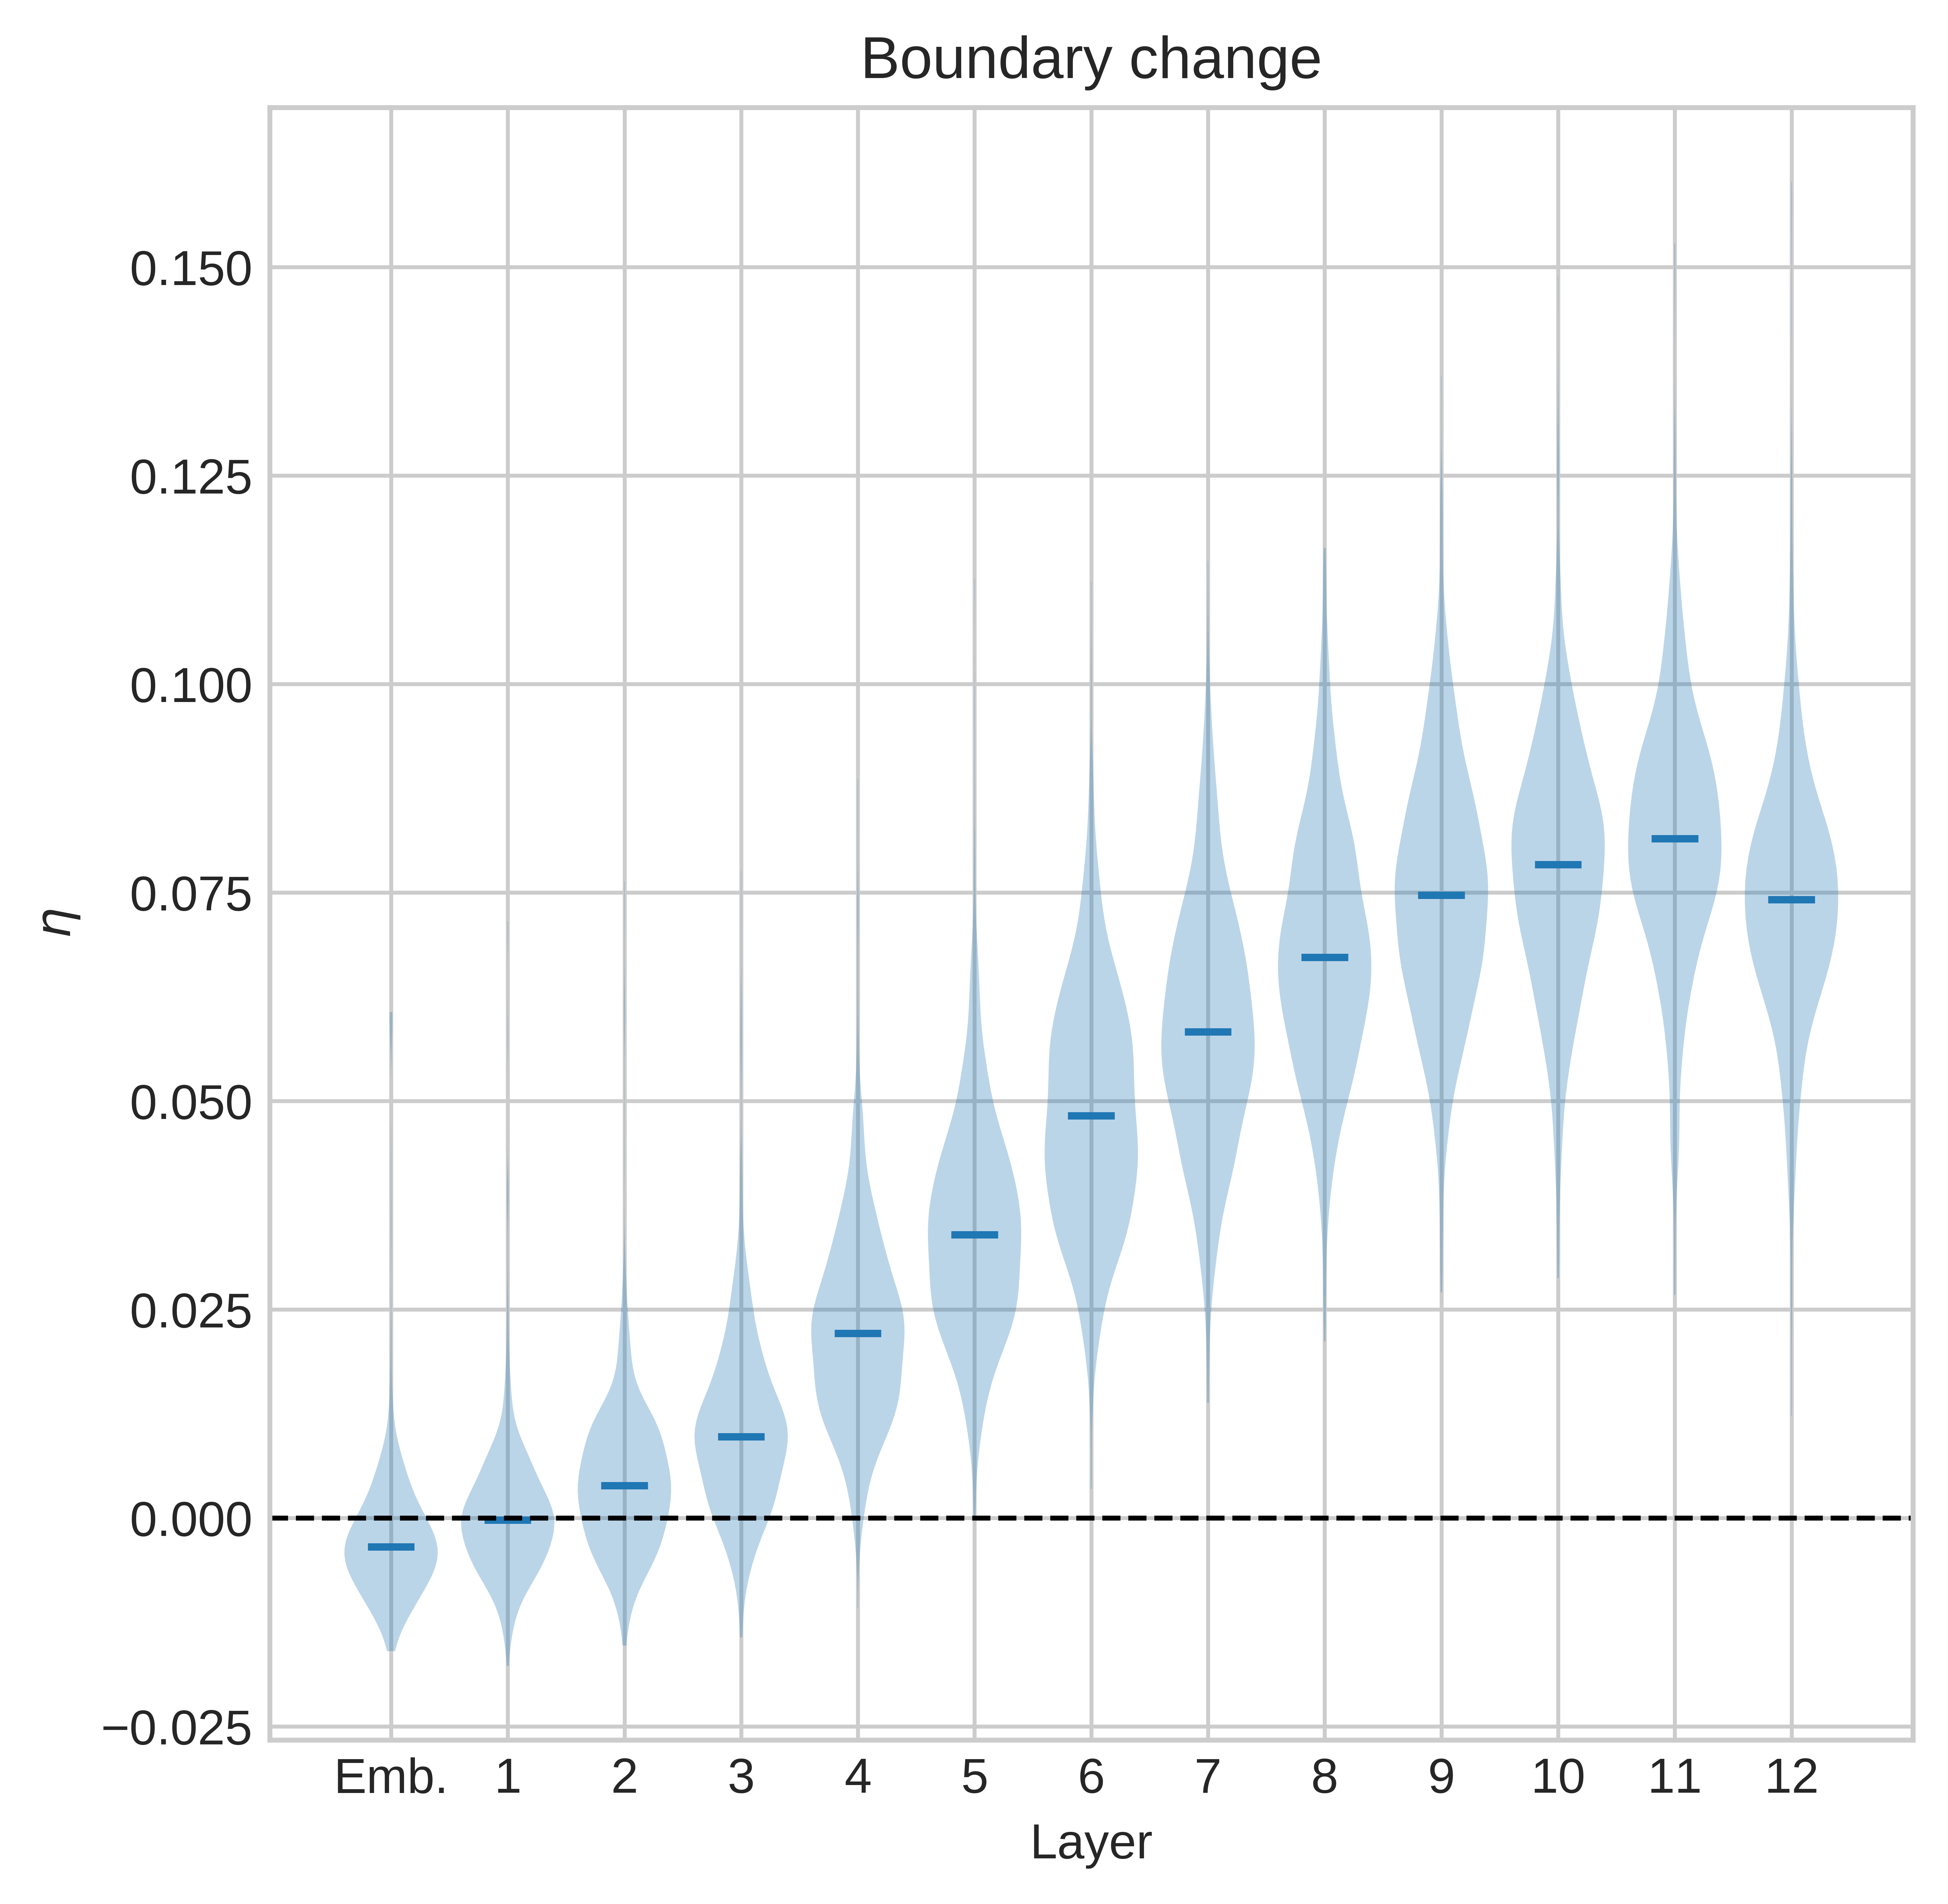

In [38]:
yoking_plots(differences_yoking.numpy(), 12,'summary')
